In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import os
import random
from datetime import datetime

import cv2
import keras
import numpy as np
import pandas as pd
from keras import backend as K
from keras.applications import *
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import *
from keras.datasets import fashion_mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import *
from keras.utils.generic_utils import CustomObjectScope
from keras.utils.vis_utils import model_to_dot
from scipy import misc
from tqdm import tqdm

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


Using TensorFlow backend.


In [18]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [3]:
def load_data():
    num_classes = 10
    (train, train_l), (x_test, y_test) = fashion_mnist.load_data()
    
    train = train.reshape((train.shape[0],28,28,1))
    x_test = x_test.reshape((x_test.shape[0],28,28,1))

    # devide into train and validation sets
    dvi = int(train.shape[0] * 0.9)
    x_train = train[:dvi]
    y_train = train_l[:dvi]
    x_val = train[dvi:]
    y_val = train_l[dvi:]
    
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_val /= 255
    x_test /= 255
    
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_val.shape[0], 'validation samples')
    print(x_test.shape[0], 'test samples')

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [28]:
def create_base_network(input_shape, MODEL):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = input
    cnn_model = MODEL(
        include_top=False, input_shape=input_shape, weights=None)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name='sim')(x)
    model = Model(input, outputs=x)
    model.load_weights('MobileNet.h5')

    return model

In [29]:
# Loading Datasets
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()
input_shape = x_train.shape[1:]

num_classes = 10
input_shape = x_train.shape[1:]

x_train shape: (54000, 28, 28, 1)
54000 train samples
6000 validation samples
10000 test samples


In [30]:
# create training+valdation positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_val == i)[0] for i in range(num_classes)]
val_pairs, val_y = create_pairs(x_val, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [36]:
try:
    with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,
                        'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D,
                       'contrastive_loss': contrastive_loss}):
        model = load_model('MobileNet_sim.h5')
        print('Load model from MobileNet_sim.h5 sucessfully.')
except:
    print('Fine-tune Network with weights trained on the Fashion-MNIST classify problem.')
    # network definition
    base_network = create_base_network(input_shape, MobileNet)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(euclidean_distance,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

    model = Model([input_a, input_b], distance)

In [ ]:
epochs = 200
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

# train
patience = 5
model_name = 'MobileNet'
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append((logs.get('loss'), logs.get("val_loss")))
        
history = LossHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(filepath=model_name + '_sim.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y),
          callbacks=[history, early_stopping, checkpointer, reduce_lr])

Train on 107320 samples, validate on 11080 samples
Epoch 1/200
107320/107320 [==============================] - 62s 577us/step - loss: 0.0910 - accuracy: 0.8862 - val_loss: 0.0800 - val_accuracy: 0.8992
Epoch 2/200
107320/107320 [==============================] - 54s 502us/step - loss: 0.0817 - accuracy: 0.9005 - val_loss: 0.0796 - val_accuracy: 0.9054
Epoch 3/200
 46720/107320 [============>.................] - ETA: 29s - loss: 0.0742 - accuracy: 0.9105

In [19]:
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,
                        'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D,
                       'contrastive_loss': contrastive_loss}):
    model = load_model('MobileNet_sim.h5')


compute final accuracy on training, validation and testing sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]], verbose=1)
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]], verbose=1)
val_acc = compute_accuracy(val_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]], verbose=1)
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on validation set: %0.2f%%' % (100 * val_acc))
print('* Accuracy on testing set: %0.2f%%' % (100 * te_acc))

19980/19980 [==============================] - 4s 216us/step
* Accuracy on validation set: 85.34%
* Accuracy on testing set: 85.04%


In [10]:
print('* Accuracy on validation set: %0.2f%%' % (100 * val_acc))
print('* Accuracy on testing set: %0.2f%%' % (100 * te_acc))

* Accuracy on validation set: 50.00%
* Accuracy on testing set: 50.00%


In [21]:
def create_recommend_pairs(sample_code, sample_label, x, digit_indices):
    '''Only positive pair creation.
    '''
    pairs = []
    n = x.shape[0]
    for i in range(n):
        z1, z2 = sample_code, i
        pairs += [[x[z1], x[z2]]]
    return np.array(pairs)

In [22]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]

10000/10000 [==============================] - 2s 217us/step


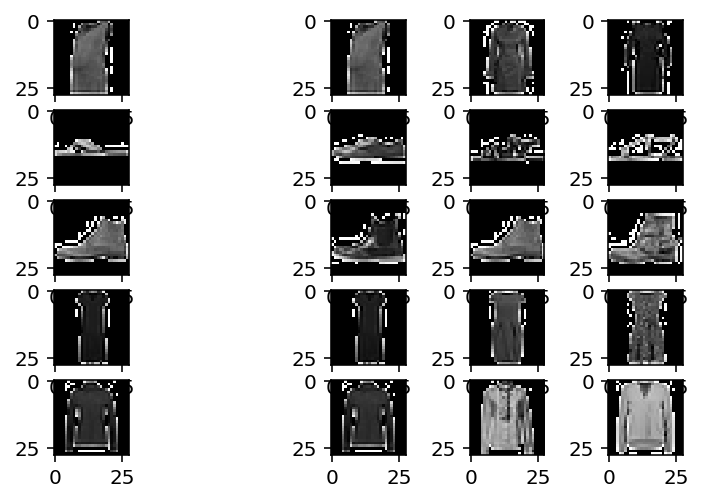

In [24]:
row = 5
column = 5
for x in range(row):
    sample_code = random.choice(range(x_test.shape[0]))
    sample_label = y_test[sample_code]
    sample = x_test[sample_code] * 255
    sample = np.concatenate((sample, sample, sample), axis=2)
    plt.subplot(row, column, 1 + x*column)
    plt.imshow(sample)
    
    # create test positive pairs
    te_pairs = create_recommend_pairs(sample_code, sample_label, x_test, digit_indices)
    
    # compute distance between recommend pairs
    y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]], verbose=1)
    
    top = np.argsort(y_pred, axis=0)[:column-2]
    for i in range(column-2):
        sample_code = top[i][0]
        sample = x_test[sample_code] * 255
        sample = np.concatenate((sample, sample, sample), axis=2)
        plt.subplot(row, column, i+3 + x*column)
        plt.imshow(sample)